In [1]:
%load_ext autoreload
%autoreload 2
import sys, os
import numpy as np
sys.path.append('../')
sys.path.append("../../../tejaas/")
from iotools.readRPKM import ReadRPKM
import pandas as pd
import numpy as np
import pandas as pd
import gzip
from utils import utils
# from gtex_normalization import normalize_expression

def centerscale_expr(Y):
    return (Y - np.mean(Y, axis = 1).reshape(-1, 1)) / np.std(Y, axis = 1).reshape(-1, 1)

In [76]:
#### correct covariates BEFORE normalization, directly on the RPKMs

def get_donors(path):
    donor_ids = list()
    with open(path, 'r') as instream:
        # skip first two lines
        next(instream)
        next(instream)
        for line in instream:
            donor_ids.append(line.strip().split()[0])
    return donor_ids

def read_gct(gct_file, donor_ids):
    """
    Load GCT as DataFrame
    """    
    df = pd.read_csv(gct_file, sep='\t', skiprows=2, index_col=0)
    df.drop('Description', axis=1, inplace=True)
    df.index.name = 'gene_id'
    df = df[[i for i in df.columns if '-'.join(i.split('-')[:2]) in donor_ids]]
    return df

### this is in the gtex_normalization.py file
import scipy.stats as stats
def normalize_quantiles(df):
    """
    Note: replicates behavior of R function normalize.quantiles from library("preprocessCore")  

    Reference:
     [1] Bolstad et al., Bioinformatics 19(2), pp. 185-193, 2003
    
    Adapted from https://github.com/andrewdyates/quantile_normalize
    """
    
    M = df.values.copy()
    
    Q = M.argsort(axis=0)
    m,n = M.shape

    # compute quantile vector
    quantiles = np.zeros(m)
    for i in range(n):
        quantiles += M[Q[:,i],i]
    quantiles = quantiles / n
    
    for i in range(n):
        # Get equivalence classes; unique values == 0
        dupes = np.zeros(m, dtype=np.int)
        for j in range(m-1):
            if M[Q[j,i],i]==M[Q[j+1,i],i]:
                dupes[j+1] = dupes[j]+1
                
        # Replace column with quantile ranks
        M[Q[:,i],i] = quantiles

        # Average together equivalence classes
        j = m-1
        while j >= 0:
            if dupes[j] == 0:
                j -= 1
            else:
                idxs = Q[j-dupes[j]:j+1,i]
                M[idxs,i] = np.median(M[idxs,i])
                j -= 1 + dupes[j]
        assert j == -1
    
    return M
      
    
def inverse_quantile_normalization(M):
    """
    After quantile normalization of samples, standardize expression of each gene
    """
    R = stats.mstats.rankdata(M,axis=1)  # ties are averaged
    Q = stats.norm.ppf(R/(M.shape[1]+1))
    return Q
        
        
# def normalize_expression(expression_df, counts_df, expression_threshold=0.1, count_threshold=5, min_samples=10):
#     """
#     Genes are thresholded based on the following expression rules:
#       >=min_samples with >expression_threshold expression values
#       >=min_samples with >count_threshold read counts
#     """
#     # donor_ids = ['-'.join(i.split('-')[:2]) for i in expression_df.columns]
#     donor_ids = expression_df.columns
    
#     # expression thresholds
#     mask = ((np.sum(expression_df>expression_threshold,axis=1)>=min_samples) & (np.sum(counts_df>count_threshold,axis=1)>=min_samples)).values
    
#     # apply normalization
#     M = normalize_quantiles(expression_df.loc[mask])
#     R = inverse_quantile_normalization(M)

#     quant_std_df = pd.DataFrame(data=R, columns=donor_ids, index=expression_df.loc[mask].index)    
#     quant_df = pd.DataFrame(data=M, columns=donor_ids, index=expression_df.loc[mask].index)
#     return quant_std_df, quant_df


### Apply LM correction (python)
from sklearn import linear_model

def lmcorrect(expression_df, cov_df):   
    donor_ids = expression_df.columns

    #sort donors
    cov_df = cov_df[expression_df.columns]

    reg = linear_model.LinearRegression()
    reg.fit(cov_df.T, expression_df.T)

    # reg.score(df_cov.T, crop_expression_df.T)
    # print(reg.coef_)
    residuals = expression_df - reg.predict(cov_df.T).T
    return residuals, reg.coef_


In [ ]:
tissue_file = "/usr/users/fsimone/trans-eqtl-pipeline/main/tissues.txt"
tissuenames, descriptions = utils.read_tissues(tissue_file)
# tissues = ["gtex-"+t for t in tissuenames]

# tissue="sse"
for tissue in tissuenames:
    print(tissue)
    rpkmpath="/cbscratch/franco/trans-eqtl/preprocess/gtex/expression/rpkms2/{:s}_rpkm.gct".format(tissue)
    countspath="/cbscratch/franco/trans-eqtl/preprocess/gtex/expression/rpkms2/{:s}_counts.gct".format(tissue)
    donorspath ="/cbscratch/franco/datasets/gtex/gtex.sample"

    expression_threshold=0.1    # 'Selects genes with > expression_threshold expression in at least min_samples')
    count_threshold=5,          # 'Selects genes with > count_threshold reads in at least min_samples')
    min_samples=10              # 'Minimum number of samples that must satisfy thresholds')

    donor_ids = get_donors(donorspath)
    expression_df = read_gct(rpkmpath, donor_ids)
    counts_df = read_gct(countspath, donor_ids)

    if expression_df.shape[1] < min_samples:
        raise ValueError("tissue has less samples than threshold")

    expr_ids = list(expression_df.columns)
    tissue_counts_df = counts_df.loc[:,expr_ids]

    # load covariates
    covfile = "/cbscratch/franco/trans-eqtl/preprocess/gtex/expression/covariates/{:s}_nopeer_covariates_w_age.txt".format(tissue)
    df_cov = pd.read_table(covfile, header=0, index_col=0)

    expr_corr_rpkms, coefs = lmcorrect_rpkms(expression_df, counts_df, df_cov)

    expr_precov_corr_norm = centerscale_expr(inverse_quantile_normalization(expr_corr_rpkms))
    expr_precov_corr_norm_df = pd.DataFrame(expr_precov_corr_norm, columns=expr_corr_rpkms.columns, index=expr_corr_rpkms.index)
    expr_precov_corr_norm_df.index.name = "gene_id"

    expr_precov_corr_norm_df.to_csv("/cbscratch/franco/trans-eqtl/preprocess/gtex/expression/lmcorrected/{:s}_age_lmcorrected.precorr.txt".format(tissue), sep="\t")

In [35]:
import warnings

def prepare_expression(counts_df, tpm_df, sample_frac_threshold=0.2, count_threshold=6, tpm_threshold=0.1, mode='tmm'):
    """
    Genes are thresholded based on the following expression rules:
      TPM >= tpm_threshold in >= sample_frac_threshold*samples
      read counts >= count_threshold in sample_frac_threshold*samples
    
    vcf_lookup: lookup table mapping sample IDs to VCF IDs
    
    Between-sample normalization modes:
      tmm: TMM from edgeR
      qn:  quantile normalization
    """

    ns = tpm_df.shape[1]

    # expression thresholds
    if mode.lower()=='tmm':
        mask = (
            (np.sum(tpm_df>=tpm_threshold,axis=1)>=sample_frac_threshold*ns) &
            (np.sum(counts_df>=count_threshold,axis=1)>=sample_frac_threshold*ns)
        ).values
    else:
        mask = (
            (np.sum(tpm_df>=tpm_threshold,axis=1)>=10) &
            (np.sum(counts_df>=count_threshold,axis=1)>=10)
        ).values

    # apply normalization
    if mode.lower()=='tmm':
        tmm_counts_df = edgeR_cpm(counts_df, normalized_lib_sizes=True)
        norm_df = inverse_quantile_normalization(tmm_counts_df[mask])
    elif mode.lower()=='qn':
        qn_df = normalize_quantiles(tpm_df.loc[mask])
        norm_df = inverse_quantile_normalization(qn_df)       
    else:
        raise ValueError('Unsupported mode {}'.format(mode))

    tmm_norm_df = pd.DataFrame(norm_df, columns=expression_df.columns, index=expression_df.index[mask])
    tmm_norm_df.index.name = "gene_id"
    
    return tmm_norm_df

def edgeR_calcNormFactors(counts_df, ref=None, logratio_trim=0.3, sum_trim=0.05, acutoff=-1e10, verbose=False):
    """
    Calculate TMM (Trimmed Mean of M values) normalization.
    Reproduces edgeR::calcNormFactors.default
    Scaling factors for the library sizes that minimize the log-fold changes between the samples for most genes.
    Effective library size: TMM scaling factor * library size
    References:
     [1] Robinson & Oshlack, 2010
     [2] R functions:
          edgeR::calcNormFactors.default
          edgeR:::.calcFactorWeighted
          edgeR:::.calcFactorQuantile
    """

    # discard genes with all-zero counts
    Y = counts_df.values.copy()
    allzero = np.sum(Y>0,axis=1)==0
    if np.any(allzero):
        Y = Y[~allzero,:]

    # select reference sample
    if ref is None:  # reference sample index
        f75 = np.percentile(Y/np.sum(Y,axis=0), 75, axis=0)
        ref = np.argmin(np.abs(f75-np.mean(f75)))
        if verbose:
            print('Reference sample index: '+str(ref))

    N = np.sum(Y, axis=0)  # total reads in each library

    # with np.errstate(divide='ignore'):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        logR = np.log2((Y/N).T / (Y[:,ref]/N[ref])).T  # log fold change; Mg in [1]
        absE = 0.5*(np.log2(Y/N).T + np.log2(Y[:,ref]/N[ref])).T  # average log relative expression; Ag in [1]
        v = (N-Y)/N/Y
        v = (v.T + v[:,ref]).T  # w in [1]

    ns = Y.shape[1]
    tmm = np.zeros(ns)
    for i in range(ns):
        fin = np.isfinite(logR[:,i]) & np.isfinite(absE[:,i]) & (absE[:,i] > acutoff)
        n = np.sum(fin)

        loL = np.floor(n*logratio_trim)+1
        hiL = n + 1 - loL
        loS = np.floor(n*sum_trim)+1
        hiS = n + 1 - loS
        rankR = stats.rankdata(logR[fin,i])
        rankE = stats.rankdata(absE[fin,i])
        keep = (rankR >= loL) & (rankR <= hiL) & (rankE >= loS) & (rankE <= hiS)
        # in [1], w erroneously defined as 1/v ?
        tmm[i] = 2**(np.nansum(logR[fin,i][keep]/v[fin,i][keep]) / np.nansum(1/v[fin,i][keep]))

    tmm = tmm / np.exp(np.mean(np.log(tmm)))
    return tmm


def edgeR_cpm(counts_df, tmm=None, normalized_lib_sizes=True):
    """
    Return edgeR normalized/rescaled CPM (counts per million)
    Reproduces edgeR::cpm.DGEList
    """
    lib_size = counts_df.sum(axis=0)
    if normalized_lib_sizes:
        if tmm is None:
            tmm = edgeR_calcNormFactors(counts_df)
        lib_size = lib_size * tmm
    return counts_df / lib_size * 1e6

In [36]:
tissue = "ms"
rpkmpath="/cbscratch/franco/trans-eqtl/preprocess/gtex/expression/rpkms2/{:s}_rpkm.gct".format(tissue)
countspath="/cbscratch/franco/trans-eqtl/preprocess/gtex/expression/rpkms2/{:s}_counts.gct".format(tissue)
donorspath ="/cbscratch/franco/datasets/gtex/gtex.sample"

donor_ids = get_donors(donorspath)
print("reading counts")
counts_df = read_gct(countspath, donor_ids)

print("reading expr")
# tpm_df = read_gct(args.tpm_gct, sample_ids) # from gtex-pipeline
expression_df = read_gct(rpkmpath, donor_ids) # my pipeline

convert_tpm = True
if convert_tpm:
    print('  * Converting to TPM')
    tpm_expr_df = expression_df/expression_df.sum(0)*1e6

# Generate normalized expression BED files for eQTL analyses
convert_tpm=True    #, help='Convert to TPM (in case input is in RPKM/FPKM)')
tpm_threshold=0.1   #, help='Selects genes with > expression_threshold expression in at least sample_frac_threshold')
count_threshold=6   #, help='Selects genes with >= count_threshold reads in at least sample_frac_threshold samples')
sample_frac_threshold=0.2  #, help='Minimum fraction of samples that must satisfy thresholds')
normalization_method='tmm' #, help='Normalization method: TMM or quantile normalization (qn)')

norm_tmm_df = prepare_expression(counts_df, tpm_expr_df, 
                             sample_frac_threshold=sample_frac_threshold,
                             count_threshold=count_threshold, tpm_threshold=tpm_threshold, 
                             mode=normalization_method)

normalization_method='qn'
norm_qn_df = prepare_expression(counts_df, expression_df, 
                             sample_frac_threshold=sample_frac_threshold,
                             count_threshold=count_threshold, tpm_threshold=tpm_threshold, 
                             mode=normalization_method)

newcolumns = ["-".join(i.split("-")[:2]) for i in norm_tmm_df.columns]
norm_tmm_df.columns = newcolumns

newcolumns = ["-".join(i.split("-")[:2]) for i in norm_qn_df.columns]
norm_qn_df.columns = newcolumns

reading counts
reading expr
  * Converting to TPM


In [37]:
norm_qn_df.head()

,GTEX-1117F,GTEX-111CU,GTEX-111FC,GTEX-111VG,GTEX-111YS,GTEX-1122O,GTEX-1128S,GTEX-113JC,GTEX-117XS,GTEX-117YW,...,GTEX-ZY6K,GTEX-ZYFC,GTEX-ZYFD,GTEX-ZYFG,GTEX-ZYT6,GTEX-ZYWO,GTEX-ZYY3,GTEX-ZZ64,GTEX-ZZPT,GTEX-ZZPU
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000227232.4,2.130272,-0.971114,0.413066,-1.548313,-2.396011,-0.287825,0.420619,-1.647538,-0.497574,-0.627416,...,1.167288,0.705237,-0.353442,-0.594039,-1.127175,0.302290,0.405537,-1.153711,1.404329,-0.932983
ENSG00000238009.2,1.462346,2.130272,-1.571692,-0.732131,0.521225,0.787585,-2.774724,-0.696385,-2.396011,-1.734255,...,0.159940,-0.251917,-0.585798,-1.039994,0.284218,2.067638,2.012200,0.309546,0.390546,1.039994
ENSG00000237683.5,0.309546,0.316819,0.083188,-1.647538,-1.101410,0.181018,0.287825,0.145928,-0.513310,-1.028175,...,-0.529174,-2.130272,1.269059,0.159940,0.013849,1.916916,0.428196,-0.635869,-0.166958,0.138933
ENSG00000239906.1,0.759566,0.266239,-0.181018,-1.472507,0.845575,-0.768839,1.253717,-0.855517,-0.787585,-0.806613,...,-2.774724,0.497574,1.703911,-1.300674,-0.537155,1.734255,-0.230531,0.906557,0.797063,-0.117988
ENSG00000228463.4,-0.714144,0.602320,1.482823,-1.962333,-0.619007,-1.386003,-2.202581,0.714144,-0.244776,-0.723108,...,0.885864,0.251917,0.394286,0.181018,-1.016498,-0.309546,-0.891002,-0.561311,-1.101410,0.383084


In [38]:
norm_tmm_df.head()

,GTEX-1117F,GTEX-111CU,GTEX-111FC,GTEX-111VG,GTEX-111YS,GTEX-1122O,GTEX-1128S,GTEX-113JC,GTEX-117XS,GTEX-117YW,...,GTEX-ZY6K,GTEX-ZYFC,GTEX-ZYFD,GTEX-ZYFG,GTEX-ZYT6,GTEX-ZYWO,GTEX-ZYY3,GTEX-ZZ64,GTEX-ZZPT,GTEX-ZZPU
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000227232.4,1.962333,-0.855517,0.173983,-1.571692,-2.288654,-0.173983,0.513310,-1.766285,-0.635869,-0.610642,...,1.181085,0.353442,-0.383084,-0.529174,-1.140342,0.295050,0.346081,-1.088798,1.088798,-0.835716
ENSG00000238009.2,1.766285,1.734255,-1.253717,-0.545172,0.360823,0.577597,-2.243542,-0.497574,-2.243542,-1.916916,...,0.428196,-0.055423,-0.778178,-1.088798,0.055423,1.800237,2.396011,0.273420,0.732131,0.825937
ENSG00000237683.5,0.360823,0.048490,0.368223,-1.571692,-1.181085,0.000000,0.166958,0.375643,-0.561311,-1.114200,...,-0.383084,-1.766285,1.223888,0.055423,-0.048490,1.675059,0.458757,-0.652913,0.104053,0.041558
ENSG00000228463.4,-0.561311,0.420619,1.525751,-1.875140,-0.652913,-1.503941,-2.067638,0.714144,-0.237647,-0.806613,...,0.938347,0.466463,0.390546,0.159940,-1.039994,-0.458757,-0.816237,-0.521225,-0.960077,0.273420
ENSG00000237094.7,2.774724,-1.253717,0.111018,-0.678843,-0.383084,0.405537,0.166958,0.398030,0.353442,-0.723108,...,-1.734255,0.076242,1.333644,-0.237647,-0.896163,0.062360,1.016498,0.152931,-0.443425,-1.916916


In [90]:

tissue="ms"
print(tissue)
rpkmpath="/cbscratch/franco/trans-eqtl/preprocess/gtex/expression/rpkms2/{:s}_rpkm.gct".format(tissue)
countspath="/cbscratch/franco/trans-eqtl/preprocess/gtex/expression/rpkms2/{:s}_counts.gct".format(tissue)
donorspath ="/cbscratch/franco/datasets/gtex/gtex.sample"

expression_threshold=0.1    # 'Selects genes with > expression_threshold expression in at least min_samples')
count_threshold=5,          # 'Selects genes with > count_threshold reads in at least min_samples')
min_samples=10              # 'Minimum number of samples that must satisfy thresholds')

donor_ids = get_donors(donorspath)
expression_df = read_gct(rpkmpath, donor_ids)
counts_df = read_gct(countspath, donor_ids)

if expression_df.shape[1] < min_samples:
    raise ValueError("tissue has less samples than threshold")

expr_ids = list(expression_df.columns)
tissue_counts_df = counts_df.loc[:,expr_ids]

newcolumns = ["-".join(i.split("-")[:2]) for i in expr_ids]
tissue_counts_df.columns = newcolumns
expression_df.columns = newcolumns

# QC Filter
expr_threshold = 0.1
count_threshold = 10
mask = (
            (np.sum(expression_df>=expr_threshold,axis=1)>=10) &
            (np.sum(tissue_counts_df>=count_threshold,axis=1)>=10)
        ).values
expression_df = expression_df.loc[mask]

print("before cs", np.linalg.matrix_rank(expression_df))

# load covariates
covfile = "/cbscratch/franco/trans-eqtl/preprocess/gtex/expression/covariates/{:s}_nopeer_covariates_w_age.txt".format(tissue)
df_cov = pd.read_table(covfile, header=0, index_col=0)

expr_qn = centerscale_expr(inverse_quantile_normalization(normalize_quantiles(expression_df)))
expr_qn_df = pd.DataFrame(expr_qn, columns=expression_df.columns, index=expression_df.index)

expr_qn_corr, coefs = lmcorrect(expr_qn_df, df_cov)

_expr_cs = centerscale_expr(expression_df.values)
print("after cs", np.linalg.matrix_rank(expression_df))
expression_df = pd.DataFrame(_expr_cs, columns=expression_df.columns, index=expression_df.index)
expr_corr, coefs = lmcorrect(expression_df, df_cov)
expr_corr_qn = inverse_quantile_normalization(expr_corr)

print(np.linalg.matrix_rank(expr_qn))
print(np.linalg.matrix_rank(expr_qn_corr))
print(np.linalg.matrix_rank(expr_corr_qn))

# expr_corr_rpkms, coefs = lmcorrect_rpkms(expression_df, counts_df, df_cov)

# expr_precov_corr_norm = centerscale_expr(inverse_quantile_normalization(expr_corr_rpkms))
# expr_precov_corr_norm_df = pd.DataFrame(expr_precov_corr_norm, columns=expr_corr_rpkms.columns, index=expr_corr_rpkms.index)
# expr_precov_corr_norm_df.index.name = "gene_id"



ms
before cs 361
after cs 361
360
353
360


In [88]:
expr_qn_corr_qn = inverse_quantile_normalization(expr_qn_corr)

print(np.linalg.matrix_rank(expr_qn_corr_qn))


360


In [86]:
df_cov.shape

(8, 302)

In [89]:
print(expression_df.shape)
print(np.linalg.matrix_rank(expression_df))


(21536, 361)
360


In [56]:
print(np.linalg.matrix_rank(norm_tmm_df.values))
print(np.linalg.matrix_rank(norm_qn_df.values))
print(np.linalg.matrix_rank(expression_df))

361
361
361


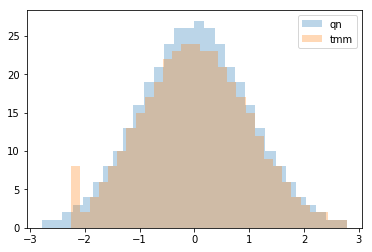

In [49]:
import matplotlib.pyplot as plt
i=1
plt.hist(norm_qn_df.iloc[i], bins=30, alpha=0.3, label="qn")
plt.hist(norm_tmm_df.iloc[i], bins=30, alpha=0.3, label="tmm")
plt.legend()
plt.show()

In [ ]:
ngene = 15000
nsample = 350
gx_rand = np.random.normal(0, 1, size = nsample * ngene).reshape((nsample, ngene))
gx_donors = random.sample(gt_donors, nsample)